In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
random_seed = 1

In [2]:
df = pd.read_csv('data/cc_data_processed.csv')

In [3]:
# Use date as index
df.index = pd.to_datetime(df['Transaction Date'])
df.drop('Transaction Date', axis = 1, inplace = True, errors='ignore')
df.head()

,Account Type,Consumer Gender,Normalized Retailer,SIC Description,Purchase Amount,Age
Transaction Date,,,,,,
2019-07-01,credit_card,male,Red Robin,Eating Places,15.52,22.0
2019-09-30,bank_account,male,California Thai,Eating Places,11.29,30.0
2019-06-24,credit_card,male,Petro-Canada,Gasoline Service Stations,10.78,34.0
2018-10-01,bank_account,female,The Beer Store,Other,88.90,43.0
2019-12-01,bank_account,male,Intermarche,Grocery Stores,23.54,62.0


In [4]:
# table with transaction counts and total amount aggregated for each month
df_group = df.groupby([pd.Grouper(freq = 'M')]).agg({'Purchase Amount': {'count', 'sum'}})
df_group.columns = ['Purchase_Sum','Transaction_Count']
df_group.head()

,Purchase_Sum,Transaction_Count
Transaction Date,,
2016-04-30,103.81,12
2016-05-31,967.50,31
2016-06-30,1346.28,48
2016-07-31,1645.19,58
2016-08-31,2971.88,88


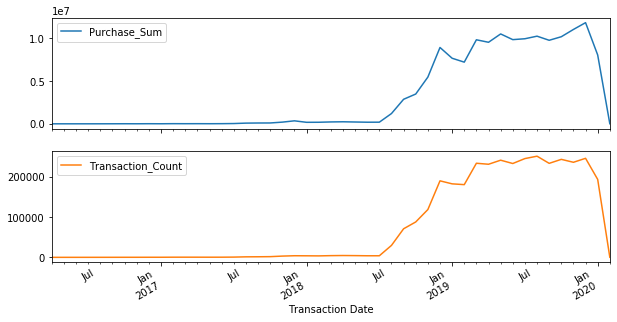

In [5]:
df_group.plot(subplots = True, y= ["Purchase_Sum","Transaction_Count"], figsize=(10,5));

                  Purchase_Sum  Transaction_Count
Transaction Date                                 
2018-09-30        2.864154e+06              70906
2018-10-31        3.476955e+06              87826
2018-11-30        5.455445e+06             118630
2018-12-31        8.910758e+06             189849
2019-01-31        7.653694e+06             182379
2019-02-28        7.199211e+06             180404
2019-03-31        9.809226e+06             233468
2019-04-30        9.517425e+06             230990
2019-05-31        1.049074e+07             241047
2019-06-30        9.825952e+06             232827
2019-07-31        9.930230e+06             245095
2019-08-31        1.023078e+07             250985
2019-09-30        9.750168e+06             233238
2019-10-31        1.016536e+07             243126
2019-11-30        1.101461e+07             235863
2019-12-31        1.180695e+07             245742
2020-01-31        8.032002e+06             193349


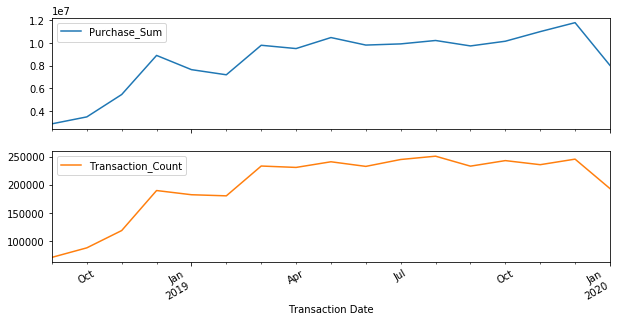

In [6]:
# only keep data from Sep 2018 to Jan 2020
df_period = df_group.loc['2018-09-01':'2020-01-31']
df_period.plot(subplots = True, y= ["Purchase_Sum","Transaction_Count"], figsize=(10,5));
print(df_period) # 17 month in total

In [7]:
# load marco economic data
df_eco = pd.read_csv('data/eco/macro_economic_data.csv')

# Extract eco data from Sep 2018 to Jan 2020
df_eco.index = pd.to_datetime(df_eco['Date'])
df_eco.drop('Date',axis = 1, inplace = True, errors='ignore')
df_eco = df_eco.loc['2018-09-01':'2020-01-31']

              CPI  Exchange_Rate_USD        GDP  Unemployment_Rate       TSX
Date                                                                        
2018-09-01  133.7             1.3037  1948264.0                5.4  16073.14
2018-10-01  134.1             1.3010  1951927.0                5.3  15027.28
2018-11-01  133.5             1.3200  1947407.0                5.2  15197.82
2018-12-01  133.4             1.3432  1947565.0                5.2  14322.86
2019-01-01  133.6             1.3301  1950566.0                6.2  15540.60
2019-02-01  134.5             1.3206  1947014.0                6.1  15999.01
2019-03-01  135.4             1.3368  1959450.0                6.2  16102.09
2019-04-01  136.0             1.3378  1965660.0                5.9  16580.73
2019-05-01  136.6             1.3459  1971646.0                5.5  16037.49
2019-06-01  136.3             1.3287  1975775.0                5.2  16382.20
2019-07-01  137.0             1.3101  1976884.0                5.9  16406.56

In [8]:
df_all = pd.concat([df_eco, df_period.set_index(df_eco.index)], axis=1)
df_all.head(20)

,CPI,Exchange_Rate_USD,GDP,Unemployment_Rate,TSX,Purchase_Sum,Transaction_Count
Date,,,,,,,
2018-09-01,133.7,1.3037,1948264.0,5.4,16073.14,2.864154e+06,70906
2018-10-01,134.1,1.3010,1951927.0,5.3,15027.28,3.476955e+06,87826
2018-11-01,133.5,1.3200,1947407.0,5.2,15197.82,5.455445e+06,118630
2018-12-01,133.4,1.3432,1947565.0,5.2,14322.86,8.910758e+06,189849
2019-01-01,133.6,1.3301,1950566.0,6.2,15540.60,7.653694e+06,182379
2019-02-01,134.5,1.3206,1947014.0,6.1,15999.01,7.199211e+06,180404
2019-03-01,135.4,1.3368,1959450.0,6.2,16102.09,9.809226e+06,233468
2019-04-01,136.0,1.3378,1965660.0,5.9,16580.73,9.517425e+06,230990
2019-05-01,136.6,1.3459,1971646.0,5.5,16037.49,1.049074e+07,241047


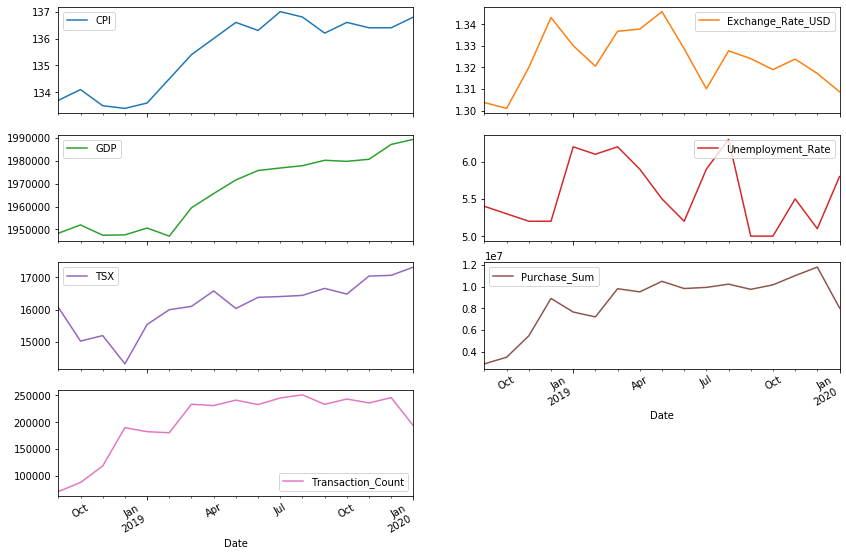

In [9]:
df_all.plot(subplots = True,figsize=(14,10),layout=(4, 2));

In [10]:
# multiple regression model
X_train = df_all[['CPI','Exchange_Rate_USD','GDP','Unemployment_Rate','TSX']].values
y_train = df_all['Purchase_Sum'].values

lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_train)

print("Linear regression R square: %.2f" % r2_score(y_train, y_pred))

Linear regression R square: 0.86
